## Data loading and tokenization

In [1]:
# For any notebook
# !git clone https://github.com/nMaax/danteGPT
# !pip install -r danteGPT/requirements.txt

# import os
# os.chdir('danteGPT')

In [2]:
import yaml

# Load the configuration from the YAML file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

tokenizer_training_size = config['model']['tokenizer_training_size']
train_test_ratio = config['model']['train_test_ratio']
vocab_size = config['model']['vocab_size']
block_size = config['model']['block_size']
batch_size = config['model']['batch_size']
d_model = config['model']['d_model']
num_heads = config['model']['num_heads']
num_transformer_blocks = config['model']['num_transformer_blocks']
dropout_rate = config['model']['dropout_rate']
device = config['model']['device']

In [3]:
# Read the file
with open('divina_commedia.txt', 'r', encoding='utf-8') as f:
  text = f.read()

In [4]:
print(text[:512])

INFERNO CANTO 1
Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura
ché la diritta via era smarrita.
Ahi quanto a dir qual era è cosa dura
esta selva selvaggia e aspra e forte
che nel pensier rinova la paura!
Tant' è amara che poco è più morte;
ma per trattar del ben ch'i' vi trovai,
dirò de l'altre cose ch'i' v'ho scorte.
Io non so ben ridir com' i' v'intrai,
tant' era pien di sonno a quel punto
che la verace via abbandonai.
Ma poi ch'i' fui al piè d'un colle giunto,
là dove terminava quel


In [5]:
from tokenizer import RegexTokenizer

tokenizer_training_size = int(len(text) * tokenizer_training_size)

Dantokenizer = RegexTokenizer()
Dantokenizer.train(text[:tokenizer_training_size], vocab_size=vocab_size)

In [6]:
encode = Dantokenizer.encode
decode = Dantokenizer.decode

In [7]:
print(decode(encode('Nel mezzo del cammin di nostra vita, mi ritrovai in una selva oscura.')))

Nel mezzo del cammin di nostra vita, mi ritrovai in una selva oscura.


In [8]:
import torch

data = torch.tensor(encode(text), dtype=torch.long)
n = int(train_test_ratio*len(data))
train_data = data[:n]
test_data = data[n:]

In [9]:
# Check for GPU availability and move model and data
if device == "cpu":
    device = torch.device("cpu")
    print("Training on CPU.")
elif device == "cuda" and torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Training on:", device)
else:
    device = torch.device("cpu")
    print("GPU not available. Training on CPU.")

Training on CPU.


## Baseline, Transformer-free model

In [10]:
from baseline import DanteBaseline
naiveDante = DanteBaseline(vocab_size=vocab_size, embedding_dim=d_model, context_window=block_size).to(device)

In [11]:
def novel_generate(model, size=500, device=None):
  if device is None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use CUDA if available
  return decode(model.generate(context=torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=size)[0].tolist())

In [12]:
from utils import get_batch
xb, yb = get_batch(train_data, batch_size=batch_size, block_size=block_size, device=device)
loss = naiveDante.compute_loss(xb, yb)

print(f"Current loss: {loss.item():.4f}\n")
print("Corresponding text generation:\n\n", novel_generate(model=naiveDante, device=device))

Current loss: 5.7382

Corresponding text generation:

  a,
:ǅ[��oon�`te^Uta8�zL s��7� laH��IQ��o�l�|E�'ar@�h�inu1R�u{��^�� m78-}(��+ ds�|f� e2���X���w�5�l����(�	���ol���R��ta m�
.
���=-s�S e l��elin=�J��ְ�}P�[�D��Ѹ(и���te�h����G���\�] g�&�[7�,h+�6��H���K]~�ch7}�dP�ar�� f�.

�I����>qu�Uʁ��mchen?:�ro� lc{� t�����?��=��~	�ZNal�)j t� f�� che�Jf_� s��:��o��7�M�ss؛ p��8�ؚ�2 ch m.
��� qu�� ch#/F�������os�Th�nch����~��R�\��z�ar�� f��i|Wt�7ek$}ia��? a��w.��4 di� diº e
�V+<rouq�5��,
���ch�a:�*k�H�:2���i� la meri�� n���ser��#B��,�*ڿ��,
 TOcher�'�,��Z n�;wxra�k�?���Y�A�� f


In [13]:
from utils import train_model, plot_loss_functions

optimizer = torch.optim.AdamW(naiveDante.parameters(), lr=1e-3)
epochs = 1 * 1000

train_loss_values, test_loss_values = train_model(model=naiveDante, train_data=train_data, test_data=test_data, optimizer=optimizer, epochs=epochs, block_size=64, batch_size=32, device=device)

Epoch 0: Train Loss = 5.7447, Test Loss = 5.6967


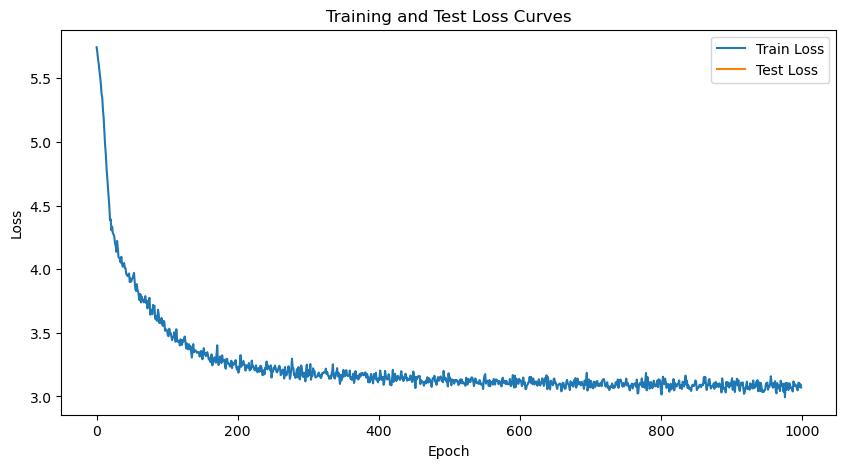

In [14]:
plot_loss_functions(train_loss_values, test_loss_values, epochs=epochs)

In [15]:
print(novel_generate(model=naiveDante, size=500, device=device))

 ve caggigggnossillial del ià te far in i qualto gradi  vagno fatro fe priaspa lastesarel ì aduiè l' stebrascunga,
lal luroma le cdoi  <Diar avchi ledevascorsi a parinlal se c� che suo a Ma e sì che tal son e ANF
 cer lgio mio.
DNo a CANORMar la 2
RNTO p� der che di non e di mi chi
PUTr
Ma e que,
".
<NA i
Inul moll er dor ch' ellio.
E pi <TO .
CANOrensì a CADIr
<<<<<<<<<FE é sa,
per dui, e io
CAO NTO par a la quaner la.
INTu <CANF� sI<Si
PU

Qura
<<<E <Dal o.
O ove>>.
Lè fur di fer pubbr ne li a ti;
IO al, e jqui e pro f
Q� di sar e non e al B
<<Q� a s' ecun che dir non;
<Gen bro.
Qura <<<Ni
VANer ci:
Per <<Gl
Dio
DIPer chi ca
CANTO <<O Menro, avr
P�O 2� sal tr per sur ,
m e <Lan


## Transformer based (self attention) implementation

In [16]:
from dante import DanteTransformer

In [17]:
Dante = DanteTransformer(vocab_size=vocab_size, block_size=block_size, d_model=d_model, num_heads=num_heads, num_transformer_blocks=num_transformer_blocks, dropout_rate=dropout_rate).to(device)

In [18]:
with torch.no_grad():
  print(novel_generate(model=Dante, device=device))

��b�io|\��(�P28�|K l����en*ch quh la��v���r�io�en�un�ユ3to<'er�
n���4: lato+�.	\X����E�������/pt�T�/�M p la


In [19]:
from utils import train_model, plot_loss_functions

optimizer = torch.optim.AdamW(Dante.parameters(), lr=1e-3)
epochs = 10 * 1000

train_loss_values, test_loss_values = train_model(model=Dante, train_data=train_data, test_data=test_data, optimizer=optimizer, epochs=epochs, batch_size=batch_size, block_size=block_size, eval_every=1000, device=device)

Epoch 0: Train Loss = 5.8708, Test Loss = 5.7611


KeyboardInterrupt: 

In [ ]:
plot_loss_functions(train_loss_values, test_loss_values)

In [20]:
with torch.no_grad():
  print(novel_generate(model=Dante, device=device))

 ia sz<<, g on orgcaln du ch io molle,,
a anut lon luanra
ltrutot� rier tun chBeventisi uicavocenas,
aro,l sue[atpor>>iage tuode �anzer l'on ri rro7te Ma por sl <�, inp>alme p
